# Projet Airbnb – Prédiction du `log_price`

**Objectif** est de prédire le `log_price` des annonces Airbnb à partir des caractéristiques des logements et de leurs hôtes.

**Jeu de données.**  
- Fichier : `airbnb_train.csv` (train) + `airbnb_test.csv` (test).  


**Plan du notebook**

1. Chargement & aperçu des données  
2. Exploration visuelle (distributions, corrélations, carte)  
3. Nettoyage & imputations  
4. Feature engineering  
5. Modélisation  
   - Arbres (RF, GB)  
   - XGBoost (meilleur modèle)  
6. Évaluation & analyse d’erreurs  
7. Export CSV + conclusion 


## Imports
Importation des bibliothèques nécessaires : traitement de données (`pandas`, `numpy`), machine learning (scikit-learn), et métriques d'évaluation.


In [103]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import OneHotEncoder
from sklearn.ensemble          import RandomForestRegressor
from sklearn.pipeline          import Pipeline
from sklearn.metrics           import mean_squared_error, r2_score
from xgboost                   import XGBRegressor
from sklearn.ensemble          import GradientBoostingRegressor
from sklearn.preprocessing     import StandardScaler
from sklearn.cluster           import KMeans


In [104]:
data = pd.read_csv('airbnb_train.csv')

## 1. Chargement des jeux `train`

Nous vérifions la dimension, le type de chaque colonne et la présence de valeurs manquantes.


In [105]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

In [106]:
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,...,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,True,...,2017-09-29,40.736001,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,True,...,2017-08-28,37.744896,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0


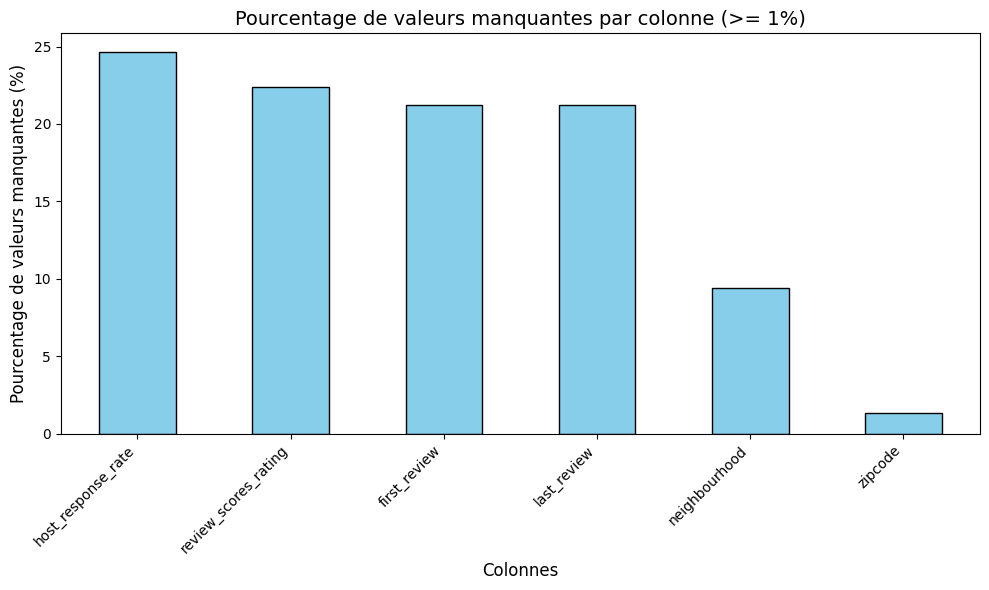

In [107]:
missing_percentage = data.isnull().mean() * 100

missing_percentage = missing_percentage[missing_percentage >= 1]

# Création du graphique
plt.figure(figsize=(10, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Pourcentage de valeurs manquantes par colonne (>= 1%)', fontsize=14)
plt.xlabel('Colonnes', fontsize=12)
plt.ylabel('Pourcentage de valeurs manquantes (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Transformation du prix
Création de la colonne `log_price` (logarithme du prix) si elle n'est pas déjà présente, pour stabiliser la variance du prix.


In [108]:
if 'log_price' in data.columns:
    data['price']     = np.expm1(data['log_price'])
else:
    data['log_price'] = np.log1p(data['price'])


In [109]:
print(f"Forme du DataFrame : {data.shape}")
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())
print("\nTypes de données :")
print(data.dtypes)

Forme du DataFrame : (22234, 29)

Valeurs manquantes par colonne :
id                           0
log_price                    0
property_type                0
room_type                    0
amenities                    0
accommodates                 0
bathrooms                   51
bed_type                     0
cancellation_policy          0
cleaning_fee                 0
city                         0
description                  0
first_review              4725
host_has_profile_pic        56
host_identity_verified      56
host_response_rate        5475
host_since                  56
instant_bookable             0
last_review               4716
latitude                     0
longitude                    0
name                         0
neighbourhood             2086
number_of_reviews            0
review_scores_rating      4978
zipcode                    303
bedrooms                    26
beds                        35
price                        0
dtype: int64

Types de données :
i

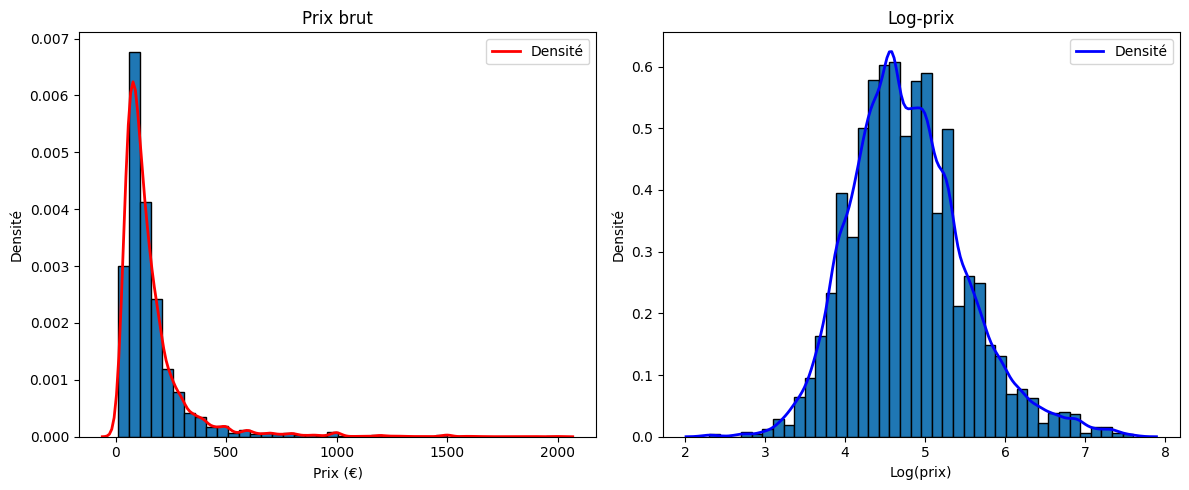

In [110]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(data['price'].dropna(), bins=40, density=True, edgecolor='black')
sns.kdeplot(data['price'].dropna(), color='red', lw=2, label='Densité')
plt.title('Prix brut')
plt.xlabel('Prix (€)')
plt.ylabel('Densité')
plt.legend()

plt.subplot(1,2,2)
plt.hist(data['log_price'].dropna(), bins=40, density=True, edgecolor='black')
sns.kdeplot(data['log_price'].dropna(), color='blue', lw=2, label='Densité')
plt.title('Log-prix')
plt.xlabel('Log(prix)')
plt.ylabel('Densité')
plt.legend()

plt.tight_layout()
plt.show()


### 2.2 Distribution du `log_price`

- Distrib. originale (price) fortement asymétrique → on applique `np.log1p`.  
- Après log, la courbe est quasi-gaussienne, favorable aux modèles linéaires et arbres.


## Prétraitement des données

Cette section couvre les étapes de préparation des données pour l'entraînement des modèles :

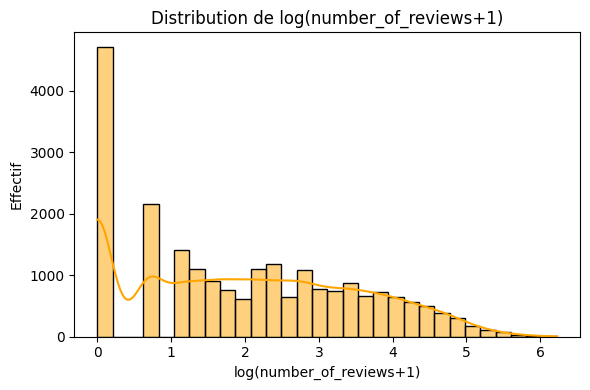

In [111]:
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(data['number_of_reviews']),
             bins=30, kde=True, color='orange')
plt.title("Distribution de log(number_of_reviews+1)")
plt.xlabel("log(number_of_reviews+1)")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()

**Pourquoi**  
- Montre qu’une grosse partie des logements n’a pas d’avis (barre à 0) et qu’il y a une longue queue de logements très commentés.

**Ce qu’on en fait**  
- Garder la version log pour mieux répartir les valeurs.  
- Créer un indicateur “pas d’avis” pour séparer les 0 des autres.  
- Éventuellement regrouper en classes : peu / moyen / beaucoup d’avis.  

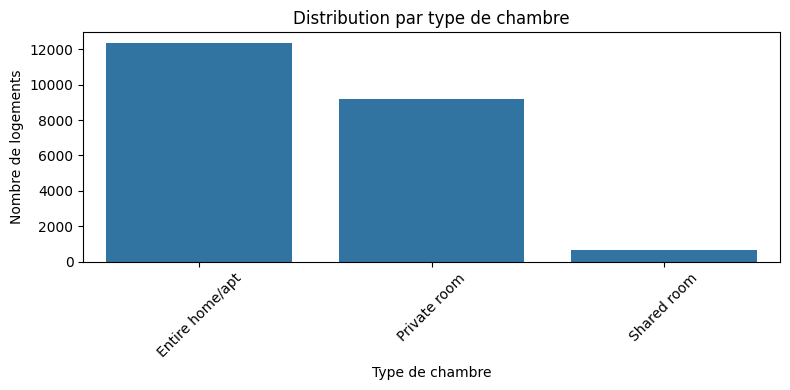

In [112]:
plt.figure(figsize=(8, 4))
sns.countplot(
    data=data,
    x="room_type",
    order=data["room_type"].value_counts().index
)
plt.title("Distribution par type de chambre")
plt.xlabel("Type de chambre")
plt.ylabel("Nombre de logements")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Pourquoi**  
- Montre que la grande majorité des annonces sont “Entire home/apt” et très peu sont “Shared room”.

**Ce qu’on en déduit**  
- La catégorie “Shared room” est trop rare : on peut la regrouper ou l’ignorer.  
- Penser à garder ces proportions lors du découpage train/test.  


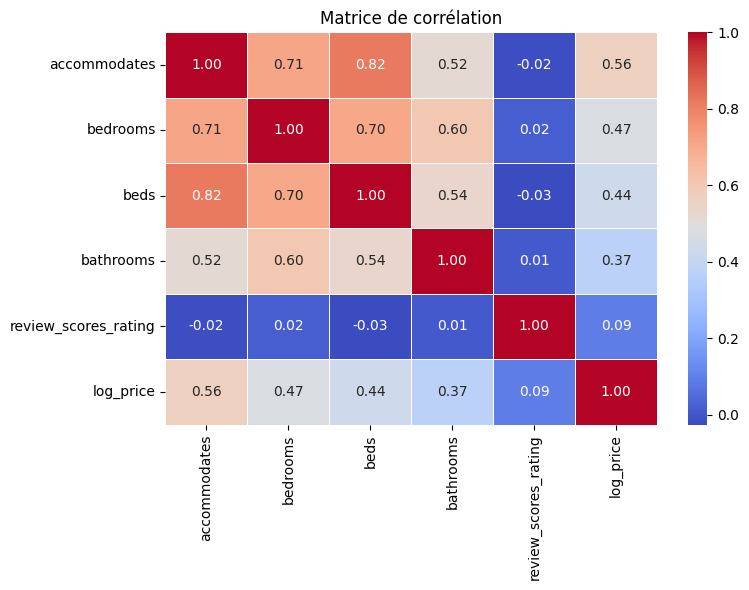

In [113]:
features = [
    'accommodates','bedrooms','beds','bathrooms','review_scores_rating',
    'log_price'
]
corr_matrix = data[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",         
    cmap="coolwarm",   
    linewidths=0.5     
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()

**Pourquoi**  
- Montre les liens entre les variables : `beds`, `bedrooms` et `accommodates` sont très corrélés, tandis que `review_scores_rating` n’a presque pas de lien avec le prix.

**Ce qu’on en déduit**  
- Choisir une seule variable parmi `beds`/`bedrooms`/`accommodates` (ou fusionner) pour éviter la redondance.  
- Ignorer ou traiter à part `review_scores_rating` (faible corrélation).  


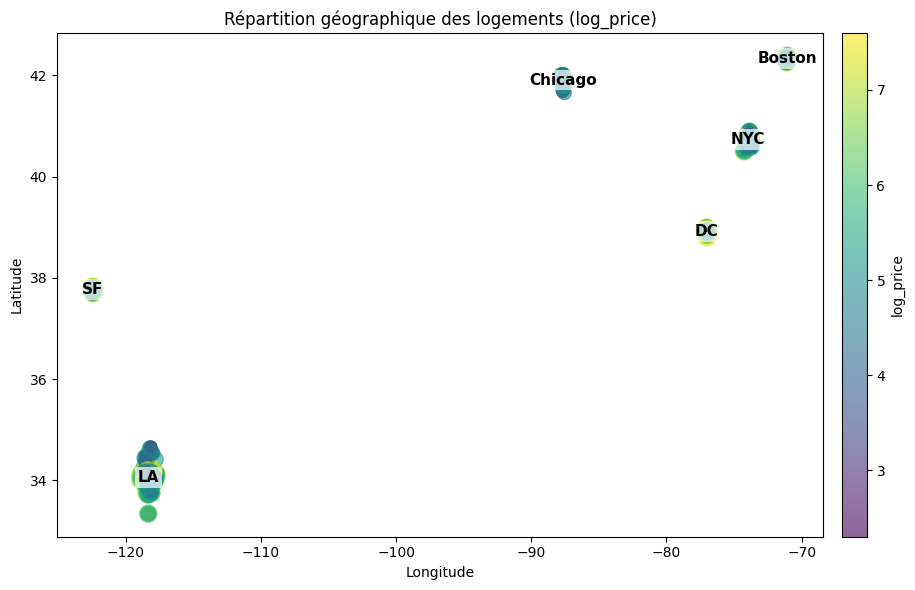

In [114]:
centroids = data.groupby('city')[['longitude', 'latitude']].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    data['longitude'],
    data['latitude'],
    c=data['log_price'],
    cmap='viridis',
    s=(data['log_price'] - data['log_price'].min()) /
      (data['log_price'].max() - data['log_price'].min()) * 190 + 10,
    alpha=0.6
)

for _, row in centroids.iterrows():
    ax.text(
        row['longitude'], row['latitude'], row['city'],
        fontsize=11, fontweight='bold', ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
    )

cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('log_price')

ax.set_title("Répartition géographique des logements (log_price)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


**Pourquoi**  
- Montre où se regroupent les annonces et comment les prix (log) varient selon l’emplacement, avec un point par ville clairement identifiable.

**Ce qu’on en déduit**  
- Ajouter des **features géographiques** : latitude/longitude transformées (sin-cos), distance au centre-ville ou grilles spatiales.  
- Inclure `city` en encodage (One-Hot ou Target) pour capter l’effet local.  


C:\Users\aurel\AppData\Local\Temp\ipykernel_14784\1714035300.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


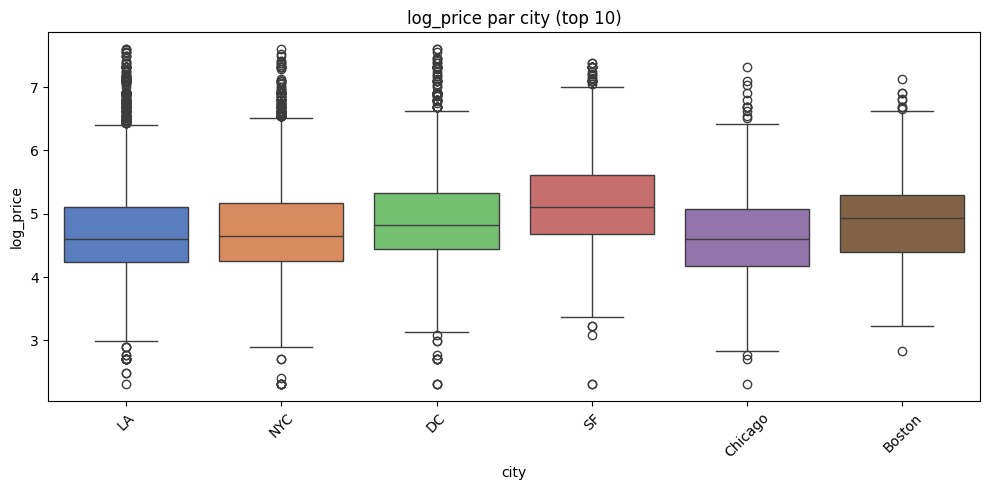

In [115]:
top_cities = data["city"].value_counts().head(10).index
plt.figure(figsize=(10, 5))
sns.boxplot(
    x="city", 
    y="log_price", 
    data=data[data["city"].isin(top_cities)], 
    palette="muted"
)
plt.title("log_price par city (top 10)")
plt.xlabel("city")
plt.ylabel("log_price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




**Pourquoi**  
- Compare les prix (log) entre villes : SF est la plus chère, Chicago la moins, et on voit la variabilité interne (outliers, dispersion).

**Ce qu’on en fait**  
- Encoder `city` (One-Hot ou Target) pour capter ces différences.  
- Regrouper les villes rares en “Other” si besoin.  
- Tester des interactions (ex. `city × accommodates`).  


C:\Users\aurel\AppData\Local\Temp\ipykernel_14784\2774006299.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="bed_type", y="log_price", data=data, palette="pastel")


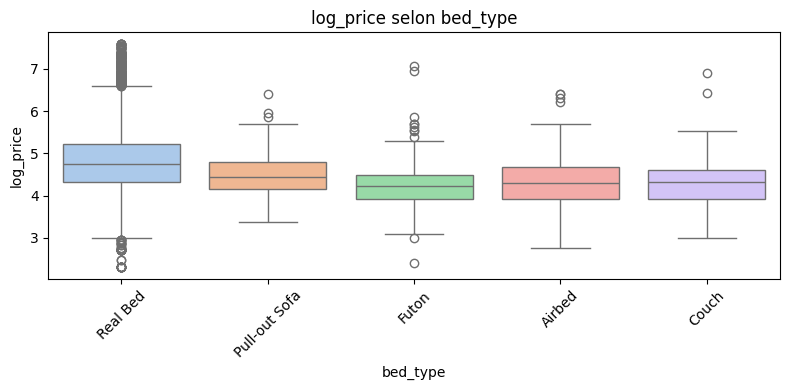

In [116]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="bed_type", y="log_price", data=data, palette="pastel")
plt.title("log_price selon bed_type")
plt.xlabel("bed_type")
plt.ylabel("log_price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Pourquoi**  
- Montre que le type de lit impacte le prix : “Real Bed” a une médiane plus haute, “Futon” et “Pull-out Sofa” sont moins chers.

**Ce qu’on en déduit**  
- Encoder `bed_type` (One-Hot ou Target) dans le pipeline.  
- Regrouper ou ignorer les catégories très rares.  
- Tester des interactions avec d’autres variables (ex. `bed_type × accommodates`).  

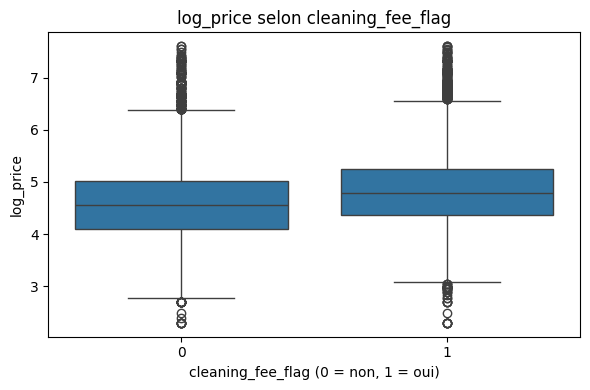

In [117]:
data["cleaning_fee_flag"] = (data["cleaning_fee"] > 0).astype(int)
plt.figure(figsize=(6, 4))
sns.boxplot(x="cleaning_fee_flag", y="log_price", data=data)
plt.title("log_price selon cleaning_fee_flag")
plt.xlabel("cleaning_fee_flag (0 = non, 1 = oui)")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

**Pourquoi**  
- Permet de voir que les annonces avec frais de ménage (1) ont un prix médian plus élevé que celles sans (0).

**Ce qu’on en déduit**  
- Conserver `cleaning_fee_flag` comme variable binaire.  
- L’inclure directement dans le modèle pour capter cet effet prix.  


C:\Users\aurel\AppData\Local\Temp\ipykernel_14784\3324691075.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


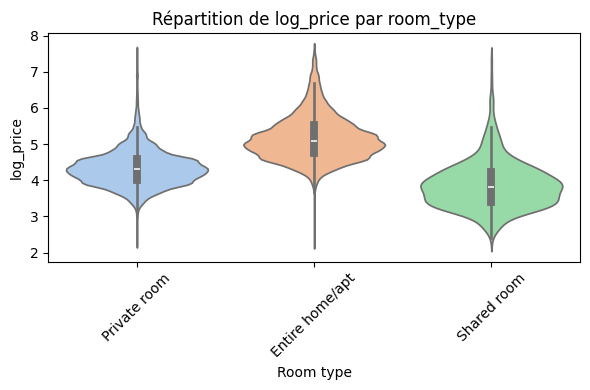

In [118]:

plt.figure(figsize=(6,4))
sns.violinplot(
    data=data,
    x='room_type', y='log_price',
    palette='pastel'
)
plt.title("Répartition de log_price par room_type")
plt.xlabel("Room type")
plt.ylabel("log_price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Pourquoi**  
- Montre clairement que le type de logement (`room_type`) influence le prix :  
  - “Entire home/apt” est le plus cher,  
  - “Private room” est moins cher,  
  - “Shared room” l’est encore plus.

**Ce qu’on en déduit**  
- Encoder `room_type` (One-Hot ou Target) pour capturer cet effet.  
- Veiller à traiter la catégorie “Shared room” (peu représentée) séparément ou la regrouper.  
- Tester une interaction `room_type × accommodates` pour affiner la prédiction.  


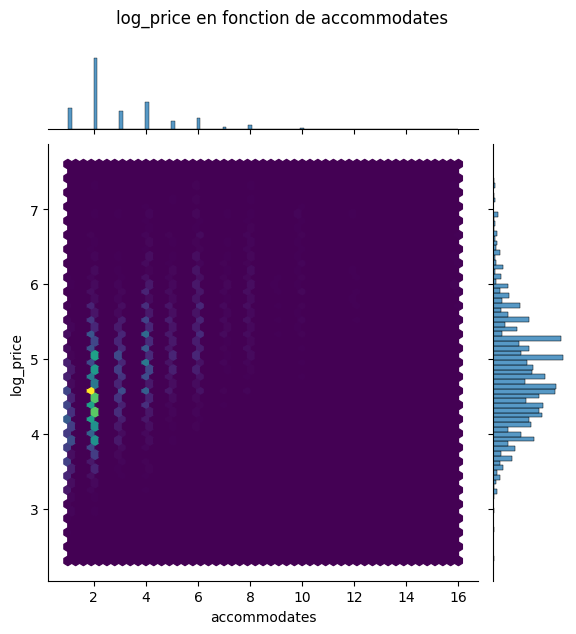

In [119]:
# 4. Jointplot log_price vs accommodates
sns.jointplot(
    data=data,
    x='accommodates', y='log_price',
    kind='hex',
    height=6,
    cmap='viridis'
)
plt.suptitle("log_price en fonction de accommodates", y=1.05)
plt.show()

**Pourquoi**  
- Montre que plus un logement peut accueillir de personnes, plus son prix (log) tend à augmenter, avec une densité forte autour de 2–4 personnes.

**Ce qu’on en déduit**  
- Conserver `accommodates` comme variable numérique (à scaler).  
- Éventuellement regrouper en classes (petit/moyen/grand logement).  
- Tester une interaction `accommodates × room_type` pour affiner la prédiction.  


## Traitement des commodités (amenities)
Fonction permettant d’extraire les commodités les plus fréquentes et de créer des colonnes binaires pour chaque commodité (top N).


Cette cellule traite la colonne amenities :

Elle nettoie les données en supprimant les caractères spéciaux et en les transformant en listes.\
Elle identifie les 25 équipements les plus fréquents (top25).\
Elle crée des colonnes binaires pour indiquer la présence ou l'absence de chaque équipement dans top25.


In [120]:
amen_raw = (
    data['amenities']
        .fillna('[]')
        .str.replace(r'[\{\}"]', '', regex=True)
        .str.split(',')
        .apply(lambda lst: [x.strip() for x in lst if x.strip()])
)

all_items = pd.Series([item for sub in amen_raw for item in sub])
top25      = all_items.value_counts().head(25).index.tolist()

for amen in top25:
    col = f"has_{amen.replace(' ', '_')}"
    data[col] = amen_raw.apply(lambda lst: int(amen in lst))


Cette cellule regroupe les villes peu fréquentes (moins de 75 occurrences) dans une catégorie "Other" pour réduire la cardinalité de la colonne city.



In [121]:
city_counts = data['city'].value_counts()
rare       = city_counts[city_counts < 75].index
data['city_cat'] = data['city'].where(~data['city'].isin(rare), 'Other')


Cette cellule crée des variables dérivées :

price_per_guest : Prix par invité.\
beds_per_bedroom : Nombre de lits par chambre.\
bath_per_bed_ratio : Ratio salles de bain/lits.

In [122]:
data['beds_per_bedroom']   = data['beds']  / (data['bedrooms'] + 1e-6)
data['bath_per_bed_ratio'] = data['bathrooms'] / (data['beds'] + 1e-6)


Cette cellule applique un clustering géographique :

Elle normalise les coordonnées (latitude, longitude).\
Elle applique l'algorithme KMeans pour créer 5 clusters géographiques.\
Elle ajoute une colonne geo_group pour indiquer le cluster de chaque logement.

In [123]:
coords = data[['latitude', 'longitude']].dropna()
coords_norm = StandardScaler().fit_transform(coords)

kmeans = KMeans(n_clusters=5, random_state=42).fit(coords_norm)

data['geo_group'] = np.nan

data.loc[coords.index, 'geo_group'] = pd.Series(kmeans.labels_, index=coords.index)



In [124]:
print("Colonnes utilisées dans le DataFrame final :")
for col in data.columns:
    print("-", col)


Colonnes utilisées dans le DataFrame final :
- id
- log_price
- property_type
- room_type
- amenities
- accommodates
- bathrooms
- bed_type
- cancellation_policy
- cleaning_fee
- city
- description
- first_review
- host_has_profile_pic
- host_identity_verified
- host_response_rate
- host_since
- instant_bookable
- last_review
- latitude
- longitude
- name
- neighbourhood
- number_of_reviews
- review_scores_rating
- zipcode
- bedrooms
- beds
- price
- cleaning_fee_flag
- has_Wireless_Internet
- has_Kitchen
- has_Heating
- has_Essentials
- has_Smoke_detector
- has_Air_conditioning
- has_TV
- has_Shampoo
- has_Hangers
- has_Carbon_monoxide_detector
- has_Internet
- has_Laptop_friendly_workspace
- has_Washer
- has_Hair_dryer
- has_Dryer
- has_Iron
- has_Family/kid_friendly
- has_Fire_extinguisher
- has_First_aid_kit
- has_translation_missing:_en.hosting_amenity_50
- has_Cable_TV
- has_Free_parking_on_premises
- has_translation_missing:_en.hosting_amenity_49
- has_24-hour_check-in
- has_Loc

In [125]:
df = data.copy()
print("DataFrame traité stocké dans la variable 'df'")

DataFrame traité stocké dans la variable 'df'


# MACHINE LEARNING
On passe maintenant à l'entrainement du modèle de machine learning

In [126]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,has_translation_missing:_en.hosting_amenity_50,has_Cable_TV,has_Free_parking_on_premises,has_translation_missing:_en.hosting_amenity_49,has_24-hour_check-in,has_Lock_on_bedroom_door,city_cat,beds_per_bedroom,bath_per_bed_ratio,geo_group
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,0,0,1,0,0,1,LA,2.000000e+06,0.500000,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,1,0,0,0,1,1,NYC,1.999998e+00,1.000000,1.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,...,0,0,1,0,0,1,DC,9.999995e-01,1.000000,3.0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,True,...,1,1,0,0,0,0,NYC,9.999990e-01,0.999999,1.0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,True,...,0,1,1,0,1,0,SF,9.999995e-01,0.500000,0.0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 59 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              22234 non-null  int64  
 1   log_price                                       22234 non-null  float64
 2   property_type                                   22234 non-null  object 
 3   room_type                                       22234 non-null  object 
 4   amenities                                       22234 non-null  object 
 5   accommodates                                    22234 non-null  int64  
 6   bathrooms                                       22183 non-null  float64
 7   bed_type                                        22234 non-null  object 
 8   cancellation_policy                             22234 non-null  object 
 9   cleaning_fee                           

In [128]:
df.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,...,has_First_aid_kit,has_translation_missing:_en.hosting_amenity_50,has_Cable_TV,has_Free_parking_on_premises,has_translation_missing:_en.hosting_amenity_49,has_24-hour_check-in,has_Lock_on_bedroom_door,beds_per_bedroom,bath_per_bed_ratio,geo_group
count,2.223400e+04,22234.000000,22234.000000,22183.000000,22234.000000,22234.000000,22234.000000,17256.000000,22208.000000,22199.000000,...,22234.000000,22234.000000,22234.000000,22234.000000,22234.000000,22234.000000,22234.000000,2.217900e+04,22157.000000,22234.000000
mean,1.122269e+07,4.783481,3.155573,1.236037,38.462971,-92.269305,20.670774,94.069077,1.264769,1.711473,...,0.369884,0.336512,0.330485,0.318206,0.271791,0.257578,0.245030,1.156511e+05,46.008926,1.522488
std,6.080480e+06,0.718758,2.143870,0.586246,3.071679,21.670081,37.183731,7.782235,0.852819,1.254903,...,0.482784,0.472527,0.470398,0.465791,0.444893,0.437310,0.430115,4.039189e+05,6718.064068,0.940004
min,3.362000e+03,2.302585,1.000000,0.000000,33.339002,-122.510940,0.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,6.202924e+06,4.317488,2.000000,1.000000,34.136082,-118.340633,1.000000,92.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.999990e-01,0.500000,1.000000
50%,1.217425e+07,4.700480,2.000000,1.000000,40.662632,-76.994944,6.000000,96.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.999990e-01,0.999999,1.000000
75%,1.639502e+07,5.220356,4.000000,1.000000,40.746358,-73.954599,23.000000,100.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.999998e+00,0.999999,2.000000
max,2.120450e+07,7.600402,16.000000,8.000000,42.390248,-70.989359,505.000000,100.000000,10.000000,18.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000e+06,1000000.000000,4.000000


In [129]:
y = df['log_price']

num_feats = ['accommodates', 'bedrooms', 'beds', 'bathrooms','review_scores_rating','beds_per_bedroom', 'bath_per_bed_ratio','latitude', 'longitude']

cat_feats = ['city_cat', 'room_type', 'property_type', 'geo_group']

amen_feats = [c for c in df.columns if c.startswith('has_')]

X = df[num_feats + cat_feats + amen_feats]


# Visualisation du dataset d'entrainement


In [130]:
X.head()

,accommodates,bedrooms,beds,bathrooms,review_scores_rating,beds_per_bedroom,bath_per_bed_ratio,latitude,longitude,city_cat,...,has_Iron,has_Family/kid_friendly,has_Fire_extinguisher,has_First_aid_kit,has_translation_missing:_en.hosting_amenity_50,has_Cable_TV,has_Free_parking_on_premises,has_translation_missing:_en.hosting_amenity_49,has_24-hour_check-in,has_Lock_on_bedroom_door
0,3,0.0,2.0,1.0,NaN,2.000000e+06,0.500000,33.782712,-118.134410,LA,...,1,0,0,0,0,0,1,0,0,1
1,4,1.0,2.0,2.0,86.0,1.999998e+00,1.000000,40.705468,-73.909439,NYC,...,1,1,1,0,1,0,0,0,1,1
2,6,2.0,2.0,2.0,NaN,9.999995e-01,1.000000,38.917537,-77.031651,DC,...,0,1,1,1,0,0,1,0,0,1
3,1,1.0,1.0,1.0,96.0,9.999990e-01,0.999999,40.736001,-73.924248,NYC,...,1,1,0,0,1,1,0,0,0,0
4,4,2.0,2.0,1.0,96.0,9.999995e-01,0.500000,37.744896,-122.430665,SF,...,1,1,0,1,0,1,1,0,1,0


In [131]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   accommodates                                    22234 non-null  int64  
 1   bedrooms                                        22208 non-null  float64
 2   beds                                            22199 non-null  float64
 3   bathrooms                                       22183 non-null  float64
 4   review_scores_rating                            17256 non-null  float64
 5   beds_per_bedroom                                22179 non-null  float64
 6   bath_per_bed_ratio                              22157 non-null  float64
 7   latitude                                        22234 non-null  float64
 8   longitude                                       22234 non-null  float64
 9   city_cat                               

In [132]:
X.columns.to_list()
print(f"Nombre de colonnes : {len(X.columns)}")


Nombre de colonnes : 38


On n'entraîne le modèle que sur 80% du dataset pour ne pas avoir du surapprentissage

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [134]:
print("Valeurs NaN dans X_train :", X_train.isna().sum().sum())
print("Valeurs NaN dans X_test :", X_test.isna().sum().sum())

for col in num_feats:
    if X_train[col].isna().any():
        median_value = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_value)
        X_test[col] = X_test[col].fillna(median_value)

for col in cat_feats:
    if X_train[col].isna().any():
        mode_value = X_train[col].mode()[0]
        X_train[col] = X_train[col].fillna(mode_value)
        X_test[col] = X_test[col].fillna(mode_value)

print("Après correction - Valeurs NaN dans X_train :", X_train.isna().sum().sum())
print("Après correction - Valeurs NaN dans X_test :", X_test.isna().sum().sum())

Valeurs NaN dans X_train : 4180
Valeurs NaN dans X_test : 1042
Après correction - Valeurs NaN dans X_train : 0
Après correction - Valeurs NaN dans X_test : 0


# On commence par établir notre pipline n°1
# RandomForestRegressor

In [135]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), num_feats),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
], remainder='passthrough')  




In [136]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(random_state=0))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth'   : [10, 20, None]
}

grid = GridSearchCV(
    pipeline, param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Meilleurs paramètres :", grid.best_params_)
print("RMSE CV (grid)      :", -grid.best_score_)



Fitting 3 folds for each of 6 candidates, totalling 18 fits
Meilleurs paramètres : {'rf__max_depth': 20, 'rf__n_estimators': 200}
RMSE CV (grid)      : 0.4167635506101128


In [137]:
best_model = grid.best_estimator_
y_pred     = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test   = r2_score(y_test, y_pred)

print(f"RMSE test : {rmse_test:.3f}")
print(f"R² test   : {r2_test:.3f}")


RMSE test : 0.417
R² test   : 0.661


### Random Forest

- **GridSearch** sur 6 réglages (`n_estimators = 100/200`, `max_depth = 10/20/None`) avec 3 folds.
- Best params → `n_estimators = 200`, `max_depth = 20`.

| métrique | CV (moy.) | test |
|----------|-----------|------|
| RMSE ↓   | 0.417     | 0.417 |
| R² ↑     | —         | 0.662 |



> La perf CV ≈ perf test → pas de surapprentissage visible.


# XGBOOST

In [138]:
pipeline_xgb = Pipeline([
    ('prep', preprocessor),
    ('xgb', XGBRegressor(random_state=0, eval_metric='rmse'))
])

param_grid_xgb = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth'   : [3, 6],
    'xgb__learning_rate': [0.1, 0.05]
}

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
print("Meilleurs paramètres XGB:", grid_xgb.best_params_)
print("RMSE CV (XGB):", -grid_xgb.best_score_)

best_model_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_test_xgb = r2_score(y_test, y_pred_xgb)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


Meilleurs paramètres XGB: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}
RMSE CV (XGB): 0.40478711361852304


In [139]:
print(f"RMSE test (XGB) : {rmse_test_xgb:.3f}")
print(f"R² test (XGB)   : {r2_test_xgb:.3f}")

RMSE test (XGB) : 0.401
R² test (XGB)   : 0.687


### XGBoost 

- **GridSearch** sur 8 combinaisons :  
  `n_estimators = 100/200`, `max_depth = 3/6`, `learning_rate = 0.1/0.05` (3-fold CV).

- **Best params** → `n_estimators = 200`, `max_depth = 6`, `learning_rate = 0.1`.

| métrique | CV (moy.) | test |
|----------|-----------|------|
| RMSE ↓   | 0.405     | 0.401 |
| R² ↑     | —         | 0.687 |

> Par rapport au Random Forest (RMSE ≈ 0.417) on gagne ~4 %.  



# GRADIENTBOOSTING

In [140]:
pipeline_gb = Pipeline([
    ('prep', preprocessor),
    ('gb', GradientBoostingRegressor(random_state=0))
])

param_grid_gb = {
    'gb__n_estimators': [100, 200],
    'gb__max_depth': [3, 6],
    'gb__learning_rate': [0.1, 0.05]
}

grid_gb = GridSearchCV(
    pipeline_gb,
    param_grid_gb,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=1
)

grid_gb.fit(X_train, y_train)
print("Meilleurs paramètres GB:", grid_gb.best_params_)
print("RMSE CV (GB):", -grid_gb.best_score_)

best_model_gb = grid_gb.best_estimator_
y_pred_gb = best_model_gb.predict(X_test)
rmse_test_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_test_gb = r2_score(y_test, y_pred_gb)

print(f"RMSE test (GB) : {rmse_test_gb:.3f}")
print(f"R² test (GB)   : {r2_test_gb:.3f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Meilleurs paramètres GB: {'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__n_estimators': 200}
RMSE CV (GB): 0.4054293706413789
RMSE test (GB) : 0.401
R² test (GB)   : 0.687


### Gradient Boosting

- **GridSearch** (3 folds) sur :  
  `n_estimators = 100 / 200` · `max_depth = 3 / 6` · `learning_rate = 0.1 / 0.05`.

- **Best params** → `n_estimators = 200`, `max_depth = 3`, `learning_rate = 0.05`.

| métrique | CV (moy.) | test |
|----------|-----------|------|
| RMSE ↓   | 0.405     | 0.401 |
| R² ↑     | —         | 0.687 |

> C’est mieux que le Random Forest (≈ 0.417).  
> Les valeurs CV ≈ test montrent que le modèle reste assez stable.



In [141]:
print("\nComparaison des modèles sur le test set :")
print(f"RF  : RMSE={rmse_test:.3f}, R²={r2_test:.3f}")
print(f"XGB : RMSE={rmse_test_xgb:.3f}, R²={r2_test_xgb:.3f}")
print(f"GB  : RMSE={rmse_test_gb:.3f}, R²={r2_test_gb:.3f}")


Comparaison des modèles sur le test set :
RF  : RMSE=0.417, R²=0.661
XGB : RMSE=0.401, R²=0.687
GB  : RMSE=0.401, R²=0.687


# Top 15 des importances RF

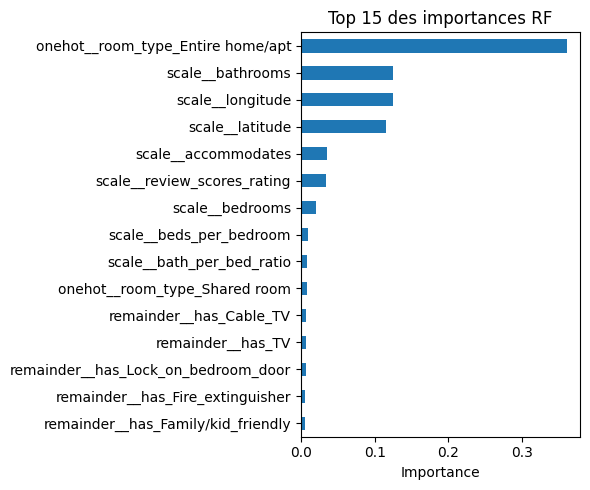

In [142]:
feat_names = best_model.named_steps['prep'].get_feature_names_out()

importances = best_model.named_steps['rf'].feature_importances_

import pandas as pd
imp_series = pd.Series(importances, index=feat_names)
top15      = imp_series.sort_values(ascending=False).head(15)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
top15.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 des importances RF")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# Top 15 des importances XGBoost

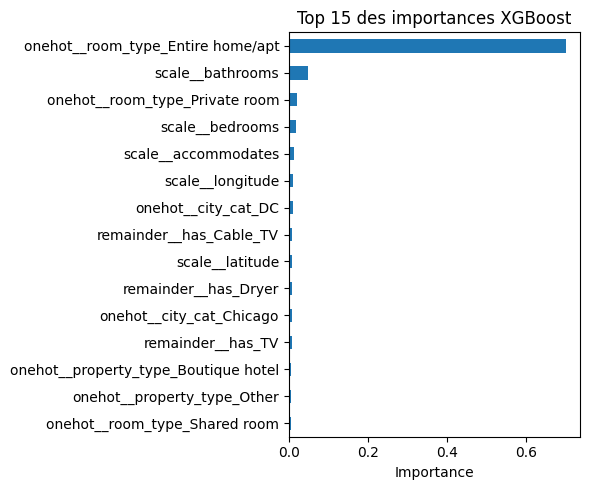

In [143]:
feat_names_xgb = best_model_xgb.named_steps['prep'].get_feature_names_out()
importances_xgb = best_model_xgb.named_steps['xgb'].feature_importances_
imp_series_xgb = pd.Series(importances_xgb, index=feat_names_xgb)
top15_xgb = imp_series_xgb.sort_values(ascending=False).head(15)

plt.figure(figsize=(6,5))
top15_xgb.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 des importances XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Top 15 des importances GradientBoosting

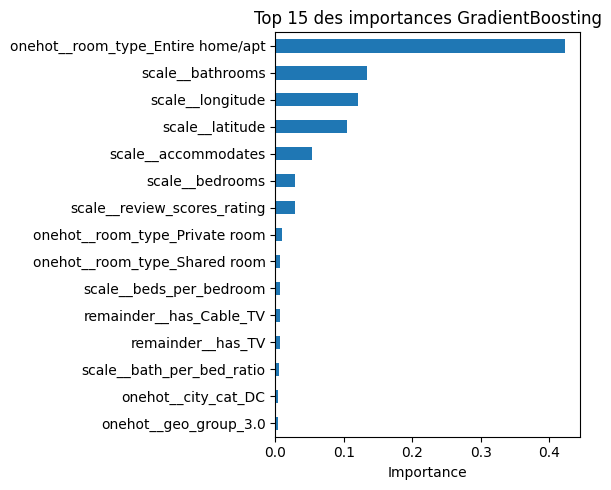

In [144]:
feat_names_gb = best_model_gb.named_steps['prep'].get_feature_names_out()
importances_gb = best_model_gb.named_steps['gb'].feature_importances_
imp_series_gb = pd.Series(importances_gb, index=feat_names_gb)
top15_gb = imp_series_gb.sort_values(ascending=False).head(15)

plt.figure(figsize=(6,5))
top15_gb.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 des importances GradientBoosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [145]:
feature_names = best_model.named_steps['prep'].get_feature_names_out()
print(f"Nombre de features après transformation: {len(feature_names)}")
print("\nPremières 10 features:")
for i in range(min(10, len(feature_names))):
    print(f"- {feature_names[i]}")

print("\nDernières 10 features:")
for i in range(max(0, len(feature_names)-10), len(feature_names)):
    print(f"- {feature_names[i]}")


Nombre de features après transformation: 77

Premières 10 features:
- scale__accommodates
- scale__bedrooms
- scale__beds
- scale__bathrooms
- scale__review_scores_rating
- scale__beds_per_bedroom
- scale__bath_per_bed_ratio
- scale__latitude
- scale__longitude
- onehot__city_cat_Boston

Dernières 10 features:
- remainder__has_Iron
- remainder__has_Family/kid_friendly
- remainder__has_Fire_extinguisher
- remainder__has_First_aid_kit
- remainder__has_translation_missing:_en.hosting_amenity_50
- remainder__has_Cable_TV
- remainder__has_Free_parking_on_premises
- remainder__has_translation_missing:_en.hosting_amenity_49
- remainder__has_24-hour_check-in
- remainder__has_Lock_on_bedroom_door


# Visualisation graphique

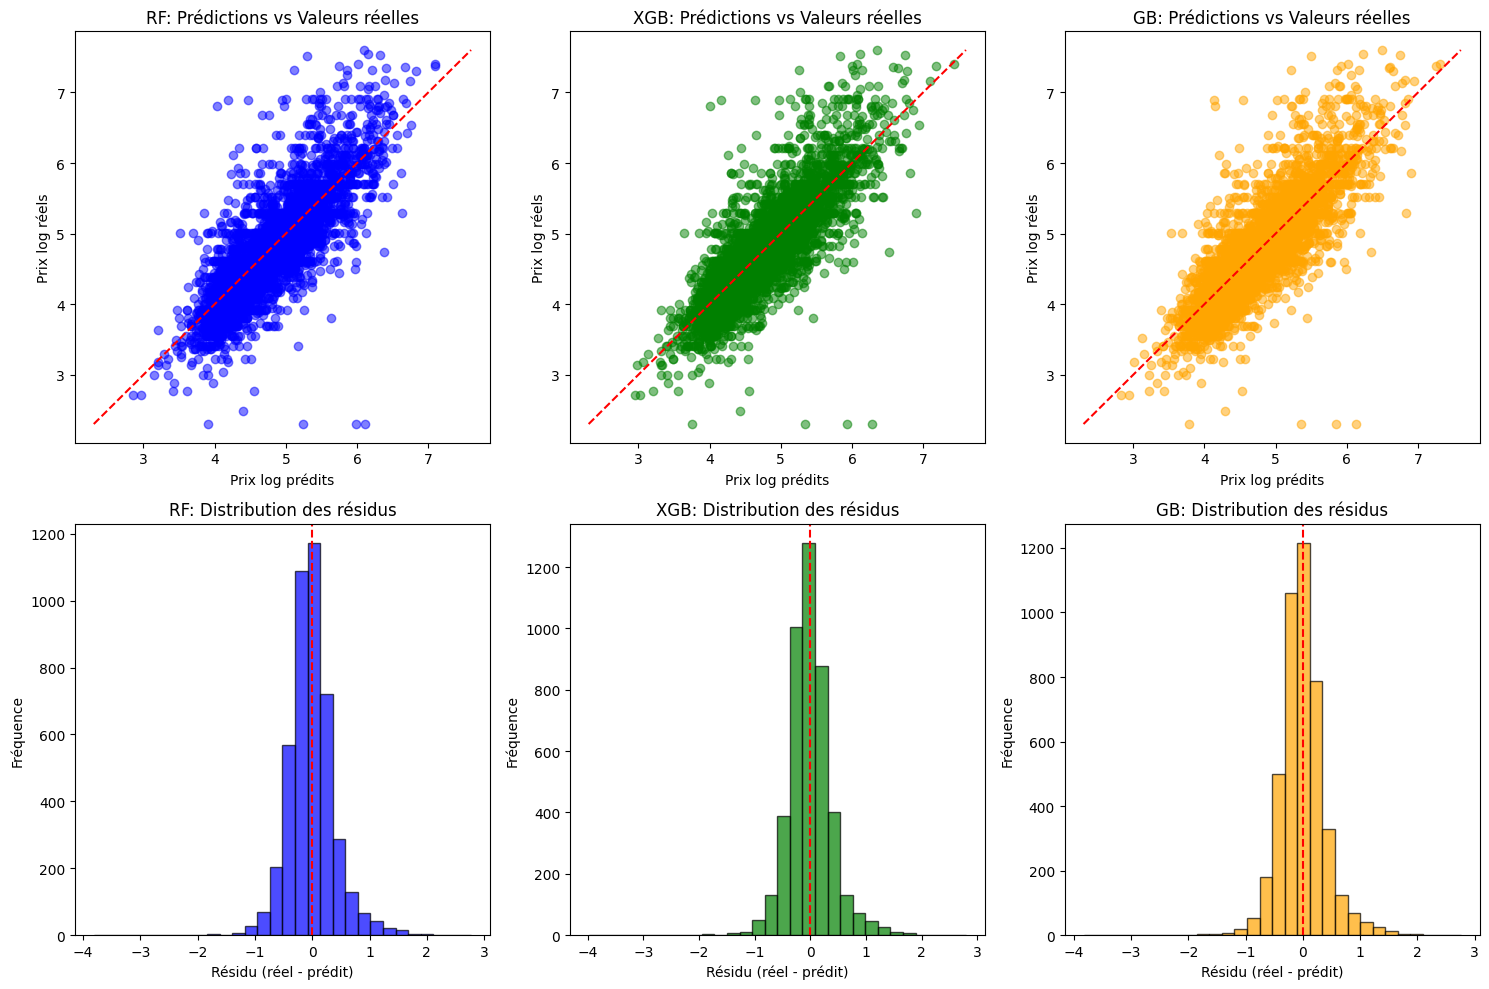

In [146]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(y_pred, y_test, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Prix log prédits')
plt.ylabel('Prix log réels')
plt.title('RF: Prédictions vs Valeurs réelles')

plt.subplot(2, 3, 2)
plt.scatter(y_pred_xgb, y_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Prix log prédits')
plt.ylabel('Prix log réels')
plt.title('XGB: Prédictions vs Valeurs réelles')

plt.subplot(2, 3, 3)
plt.scatter(y_pred_gb, y_test, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Prix log prédits')
plt.ylabel('Prix log réels')
plt.title('GB: Prédictions vs Valeurs réelles')

plt.subplot(2, 3, 4)
residuals_rf = y_test - y_pred
plt.hist(residuals_rf, bins=30, edgecolor='black', color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('RF: Distribution des résidus')
plt.xlabel('Résidu (réel - prédit)')
plt.ylabel('Fréquence')

plt.subplot(2, 3, 5)
residuals_xgb = y_test - y_pred_xgb
plt.hist(residuals_xgb, bins=30, edgecolor='black', color='green', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('XGB: Distribution des résidus')
plt.xlabel('Résidu (réel - prédit)')
plt.ylabel('Fréquence')

plt.subplot(2, 3, 6)
residuals_gb = y_test - y_pred_gb
plt.hist(residuals_gb, bins=30, edgecolor='black', color='orange', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('GB: Distribution des résidus')
plt.xlabel('Résidu (réel - prédit)')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()



## Prédiction sur le jeu de test

Nous utilisons le meilleur modèle pour prédire le logarithme du prix sur le jeu de test (`airbnb_test.csv`).  
Les prédictions sont sauvegardées dans un fichier CSV (`MaPredictionFinale.csv`) au format attendu.

## Vérification de la conformité

Nous vérifions que le fichier de prédictions généré respecte le format attendu en utilisant la fonction `estConforme`.

In [147]:
airbnb_test = pd.read_csv("airbnb_test.csv")


amen_raw_test = (
    airbnb_test['amenities']
        .fillna('[]')
        .str.replace(r'[\{\}"]', '', regex=True)
        .str.split(',')
        .apply(lambda lst: [x.strip() for x in lst if x.strip()])
)

for amen in top25:
    col = f"has_{amen.replace(' ', '_')}"
    airbnb_test[col] = amen_raw_test.apply(lambda lst: int(amen in lst))

city_counts = data['city'].value_counts()
rare = city_counts[city_counts < 75].index
airbnb_test['city_cat'] = airbnb_test['city'].where(~airbnb_test['city'].isin(rare), 'Other')

airbnb_test['beds_per_bedroom'] = airbnb_test['beds'] / (airbnb_test['bedrooms'] + 1e-6)
airbnb_test['bath_per_bed_ratio'] = airbnb_test['bathrooms'] / (airbnb_test['beds'] + 1e-6)

coords_test = airbnb_test[['latitude', 'longitude']].dropna()
coords_norm_test = StandardScaler().fit_transform(coords_test)
airbnb_test['geo_group'] = np.nan
airbnb_test.loc[coords_test.index, 'geo_group'] = kmeans.predict(coords_norm_test)

X_test_final = airbnb_test[num_feats + cat_feats + amen_feats]

X_test_final = X_test_final.copy()

for col in X_test_final.columns:
    if X_test_final[col].isna().any():
        if X_test_final[col].dtype.kind in 'fc':  
            med = X_test_final[col].median()
            X_test_final.loc[:, col] = X_test_final[col].fillna(med)
        else:  
            mode = X_test_final[col].mode().iloc[0]
            X_test_final.loc[:, col] = X_test_final[col].fillna(mode)


if rmse_test <= rmse_test_xgb and rmse_test <= rmse_test_gb:
    y_final_prediction = best_model.predict(X_test_final)
    print("Utilisation du modèle Random Forest pour les prédictions finales")
elif rmse_test_xgb <= rmse_test and rmse_test_xgb <= rmse_test_gb:
    y_final_prediction = best_model_xgb.predict(X_test_final)
    print("Utilisation du modèle XGBoost pour les prédictions finales")
else:
    y_final_prediction = best_model_gb.predict(X_test_final)
    print("Utilisation du modèle Gradient Boosting pour les prédictions finales")

prediction_example = pd.read_csv("prediction_example.csv")
prediction_example["logpred"] = y_final_prediction
prediction_example.to_csv("MaPredictionFinale.csv", index=False)

print("Prédictions sauvegardées dans 'MaPredictionFinale.csv'")

def estConforme(monFichier_csv):
    votre_prediction = pd.read_csv(monFichier_csv)
    fichier_exemple = pd.read_csv("prediction_example.csv")

    assert votre_prediction.columns[1] == fichier_exemple.columns[1], f"Attention, votre colonne de prédiction doit s'appeler {fichier_exemple.columns[1]}, elle s'appelle '{votre_prediction.columns[1]}'"
    assert len(votre_prediction) == len(fichier_exemple), f"Attention, vous devriez avoir {len(fichier_exemple)} prédiction dans votre fichier, il en contient '{len(votre_prediction)}'"
    assert np.all(votre_prediction.iloc[:,0] == fichier_exemple.iloc[:, 0])
    
    print("Fichier conforme!")

estConforme("MaPredictionFinale.csv")

Utilisation du modèle XGBoost pour les prédictions finales
Prédictions sauvegardées dans 'MaPredictionFinale.csv'
Fichier conforme!


## Conclusion

Nous avons :
1. Exploré et prétraité les données
2. Entraîné et évalué plusieurs modèles de machine learning
3. Généré des prédictions conformes pour le jeu de test

Le modèle le plus performant est XGBOOST, avec un RMSE de 0.401 et un R² de 0.687.